Created: 4/3/24
Updated: 4/3/24
Author: Nicholas Ackerman
Purpose: Mix Rate BNC Retention analysis that utilzies combinations and timeframes to produce detailed chart of the most and least impactful segments on 30 and 60 day retention rates. The idea of this program will be to have the user submit multiple imputs
[timeframe, segmentation level, segments, etc] and have the mix rate calcualtion be completed at the level intentended. The program reaches out to Snowflake to pull in raw data from the ESA_MIX_RATE_SEGMENTATION table. 

In [1]:
#import libraries
from snowflake.sqlalchemy import URL
from sqlalchemy import create_engine
from datetime import datetime, timezone, timedelta
from itertools import combinations
from itertools import permutations
import datetime as dt
import random
import pandas as pd
import numpy as np
from snowflake.connector.pandas_tools import pd_writer
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
#Link to Documentation

In [2]:
#Connection setup and functions
class SFConnection:
    def __init__(self):
        self.name = ''
        self.connection = ''
        self.engine = ''

    def open_conn(self):
        username = self.name + '@safeway.com'
        account_identifier = 'abs_itds_prd.west-us-2.privatelink'

        # Create an engine to connect to Snowflake
        self.engine = create_engine(
        f'snowflake://{username}@{account_identifier}/?authenticator=externalbrowser'
        )
        self.connection = self.engine.connect()
        print("Connection Opened")

    def test_conn(self):
        try:
            self.open_conn()
            results = self.connection.execute('select current_version()').fetchone()
            print("Snowflake connected to Version: {}".format(results[0]))
            return("CONNECTED")
        except Exception as e:
            print("Snowflake connection Error")
            return("ERR")

    def run_query(self, sql):
        self.connection.execute("BEGIN")
        self.connection.execute(sql)
        self.connection.execute("COMMIT")

    def query_to_df(self, sql):
        results = self.connection.execute(sql).fetchall()
        columns = results[0].keys()
        return pd.DataFrame(results, columns=columns)
        
    def close_conn(self):
        self.connection.close()
        self.engine.dispose()
        print("Connection Closed")

    def add_name(self, name):
        self.name = name
    
    #accepts a dataframe and a table name in lowercase. It is fixed currently to the FBI Schema. You only need to pass through the tablename
    #The df must be in the exact format as table
    #This will upload in chuncks of 10,000 rows to Snowflake
    #This method will replace all current values from Dataframe 
    def load_dataframe_REPLACE(self, inputdf, tablename):
        inputdf.to_sql(name=tablename.lower(), con=self.engine, if_exists='replace', index=False, chunksize=10000)
    
    #Method for inserting value without replacing to data tables 
    def load_dataframe_APPEND(self, inputdf, tablename):
        inputdf.to_sql(name=tablename.lower(), con=self.engine, if_exists='append', index=False, chunksize=10000)

In [3]:
#--Query needed for Proactive Communication to show the difference in 30 day retention before and after Proactive went live. Specifically in Jewel Osco
'''

'''

SQL_TIMEFRAME_INITAL = '''
select 
fiscal_year_id,
previous_store_sales_category,
mrs.DELIVERY_TYPE, 
mrs.SVCLVL_TYPE,
mrs.DIVISION,
mrs.URBANICITY,
--CASE WHEN FRST_TXN_SAVE20_PROMO_CODE_FLAG > 0 or FRST_TXN_SAVE30_PROMO_CODE_FLAG > 0 OR CYBER_CODE > 0 THEN 'USED PROMO CODE' else 'DID NOT USE PROMO CODE' end as Promo_usage,
count(distinct household_id) as Total_Households,
count (distinct case when repeat_30_days_ecomm > 0 then household_id end) as Repeat_30_day,
count (distinct case when repeat_30_days_ecomm > 0 then household_id end) / count(distinct household_id) AS RETENTION_30_DAY,
count (distinct case when repeat_60_days_ecomm > 0 then household_id end) as Repeat_60_day,
count (distinct case when repeat_60_days_ecomm > 0 then household_id end) / count(distinct household_id) AS RETENTION_60_DAY
from "EDM_BIZOPS_PRD"."FBI"."ESA_MIX_RATE_SEGMENTATION" mrs
left join "EDM_BIZOPS_PRD"."FBI"."ESA_HOLISTIC_SCORECARD_TXN_CUSTOMER_SEGMENT" cs
on mrs.txn_id = cs.txn_id
WHERE 
cs.segment_1 IN ('BNC TO ACI', 'BNC TO ECOMM')
AND fiscal_year_id = '2022'
group by 
fiscal_year_id,
previous_store_sales_category,
mrs.DELIVERY_TYPE, 
mrs.SVCLVL_TYPE,
mrs.DIVISION,
mrs.URBANICITY
'''

SQL_TIMEFRAME_FINAL = '''
select 
fiscal_year_id,
previous_store_sales_category,
mrs.DELIVERY_TYPE, 
mrs.SVCLVL_TYPE,
mrs.DIVISION,
mrs.URBANICITY,
--CASE WHEN FRST_TXN_SAVE20_PROMO_CODE_FLAG > 0 or FRST_TXN_SAVE30_PROMO_CODE_FLAG > 0 OR CYBER_CODE > 0 THEN 'USED PROMO CODE' else 'DID NOT USE PROMO CODE' end as Promo_usage,
count(distinct household_id) as Total_Households,
count (distinct case when repeat_30_days_ecomm > 0 then household_id end) as Repeat_30_day,
count (distinct case when repeat_30_days_ecomm > 0 then household_id end) / count(distinct household_id) AS RETENTION_30_DAY,
count (distinct case when repeat_60_days_ecomm > 0 then household_id end) as Repeat_60_day,
count (distinct case when repeat_60_days_ecomm > 0 then household_id end) / count(distinct household_id) AS RETENTION_60_DAY
from "EDM_BIZOPS_PRD"."FBI"."ESA_MIX_RATE_SEGMENTATION" mrs
left join "EDM_BIZOPS_PRD"."FBI"."ESA_HOLISTIC_SCORECARD_TXN_CUSTOMER_SEGMENT" cs
on mrs.txn_id = cs.txn_id
WHERE 
cs.segment_1 IN ('BNC TO ACI', 'BNC TO ECOMM')
AND fiscal_year_id = '2023'
group by 
fiscal_year_id,
previous_store_sales_category,
mrs.DELIVERY_TYPE, 
mrs.SVCLVL_TYPE,
mrs.DIVISION,
mrs.URBANICITY
'''

#Connection String Created and Query Pulled
conn = SFConnection()
conn.add_name('NACKE08') #Change to Current User LDAP
conn.test_conn()
dfTF1= conn.query_to_df(SQL_TIMEFRAME_INITAL)
dfTF2 = conn.query_to_df(SQL_TIMEFRAME_FINAL)
conn.close_conn()

Initiating login request with your identity provider. A browser window should have opened for you to complete the login. If you can't see it, check existing browser windows, or your OS settings. Press CTRL+C to abort and try again...
Connection Opened
Snowflake connected to Version: 8.13.1
Connection Closed


In [134]:
def MIX_RATE_FUNCTION(combination_columns):
    #COLUMN AGGREGATION
    #
    #///////////////////////////////////////////////////////////////////////
    # INITIAL TIME PERIOD
    #///////////////////////////////////////////////////////////////////////
    #
    dfTemp1 = pd.DataFrame()
    dfTemp1['TOTAL_HH'] = dfTF1.groupby(combination_columns)['total_households'].sum()
    dfTemp1['TOTAL_HH_PCT'] = dfTF1.groupby(combination_columns)['total_households'].sum() / dfTF1['total_households'].sum()
    dfTemp1['RPT_30_HH'] = dfTF1.groupby(combination_columns)['repeat_30_day'].sum()
    dfTemp1['RPT_RATE_30'] = dfTF1.groupby(combination_columns)['repeat_30_day'].sum() / dfTF1.groupby(combination_columns)['total_households'].sum()
    dfTemp1['RPT_60_HH'] = dfTF1.groupby(combination_columns)['repeat_60_day'].sum()
    dfTemp1['RPT_RATE_60'] = dfTF1.groupby(combination_columns)['repeat_60_day'].sum() / dfTF1.groupby(combination_columns)['total_households'].sum()
    #
    #///////////////////////////////////////////////////////////////////////
    # FINAL TIME PERIOD
    #///////////////////////////////////////////////////////////////////////
    #
    dfTemp2 = pd.DataFrame()
    dfTemp2['TOTAL_HH'] = dfTF2.groupby(combination_columns)['total_households'].sum()
    dfTemp2['TOTAL_HH_PCT'] = dfTF2.groupby(combination_columns)['total_households'].sum() / dfTF2['total_households'].sum()
    dfTemp2['RPT_30_HH'] = dfTF2.groupby(combination_columns)['repeat_30_day'].sum()
    dfTemp2['RPT_RATE_30'] = dfTF2.groupby(combination_columns)['repeat_30_day'].sum() / dfTF2.groupby(combination_columns)['total_households'].sum()
    dfTemp2['RPT_60_HH'] = dfTF2.groupby(combination_columns)['repeat_60_day'].sum()
    dfTemp2['RPT_RATE_60'] = dfTF2.groupby(combination_columns)['repeat_60_day'].sum() / dfTF2.groupby(combination_columns)['total_households'].sum()
    #
    #///////////////////////////////////////////////////////////////////////
    # OVERALL GROUPS
    #///////////////////////////////////////////////////////////////////////
    #
    dfOverall = pd.DataFrame()
    dfOverall['INITIAL_TOTAL_HH'] = [dfTF1['total_households'].sum()]
    dfOverall['INITIAL_RPT_RATE_30'] = [dfTF1['repeat_30_day'].sum() / dfTF1['total_households'].sum()]
    dfOverall['INITIAL_RPT_RATE_60'] = [dfTF1['repeat_60_day'].sum() / dfTF1['total_households'].sum()]
    dfOverall['FINAL_TOTAL_HH'] = [dfTF2['total_households'].sum()]
    dfOverall['FINAL_RPT_RATE_30'] = [dfTF2['repeat_30_day'].sum() / dfTF2['total_households'].sum()]
    dfOverall['FINAL_RPT_RATE_60'] = [dfTF2['repeat_60_day'].sum() / dfTF2['total_households'].sum()]
    #Mix Rate Calcualtion 
    #
    #///////////////////////////////////////////////////////////////////////
    # 30 DAY RETENTION MIX RATE CONTRIBUTION
    #///////////////////////////////////////////////////////////////////////
    #
    dfTemp2['VARIANCE'] = dfTemp2['TOTAL_HH_PCT'] - dfTemp1['TOTAL_HH_PCT'] #Varience 
    dfTemp2['RPT_RATE_30_BPS_DIFF'] = (dfTemp2['RPT_RATE_30'] - dfTemp1['RPT_RATE_30'])*10000 #30 day repeat BPD Diff
    dfTemp2['30_DAY_RATE_CONTRIBUTION'] = dfTemp2['RPT_RATE_30_BPS_DIFF'] * dfTemp2['TOTAL_HH_PCT'] #30 day Rate Contribution
    dfTemp2['30_DAY_MIX_CONTRIBUTION'] = ((dfTemp1['RPT_RATE_30'] - dfOverall['INITIAL_RPT_RATE_30'][0]) * dfTemp2['VARIANCE'])*10000 #30 day Mix Contribution
    dfTemp2['TOTAL_CONTRIBUTION_30_DAYS'] = dfTemp2['30_DAY_RATE_CONTRIBUTION'] + dfTemp2['30_DAY_MIX_CONTRIBUTION']
    #
    #///////////////////////////////////////////////////////////////////////
    # 60 DAY RETENTION MIX RATE CONTRIBUTION
    #///////////////////////////////////////////////////////////////////////
    #
    dfTemp2['RPT_RATE_60_BPS_DIFF'] = (dfTemp2['RPT_RATE_60'] - dfTemp1['RPT_RATE_60'])*10000 #60 day repeat BPD Diff
    dfTemp2['60_DAY_RATE_CONTRIBUTION'] = dfTemp2['RPT_RATE_60_BPS_DIFF'] * dfTemp2['TOTAL_HH_PCT'] #60 day Rate Contribution
    dfTemp2['60_DAY_MIX_CONTRIBUTION'] = ((dfTemp1['RPT_RATE_60'] - dfOverall['INITIAL_RPT_RATE_60'][0]) * dfTemp2['VARIANCE'])*10000 #60 day Mix Contribution
    dfTemp2['TOTAL_CONTRIBUTION_60_DAYS'] = dfTemp2['60_DAY_RATE_CONTRIBUTION'] + dfTemp2['60_DAY_MIX_CONTRIBUTION']
    dfTemp2
    #Mix Rate Calcualtion return values
    #
    #///////////////////////////////////////////////////////////////////////
    # 30 DAY RETENTION MIX RATE CONTRIBUTION
    #///////////////////////////////////////////////////////////////////////
    #
    dfFINAL = pd.DataFrame()
    dfFINAL['TOTAL_CONTRIBUTION_30_DAYS'] = dfTemp2['TOTAL_CONTRIBUTION_30_DAYS']
    dfFINAL['TOTAL_CONTRIBUTION_60_DAYS'] = dfTemp2['TOTAL_CONTRIBUTION_60_DAYS']
    dfFINAL['FEATURES'] = '::'.join(combination_columns)
    dfFINAL['NUM_FEATURES'] = len(combination_columns)
    #dfFINAL['NUM_HH_FIRST_TIMEPERIOD'] = dfTemp1['TOTAL_HH']
    #dfFINAL['NUM_HH_LAST_TIMEPERIOD'] = dfTemp2['TOTAL_HH']
    #dfFINAL['VARIANCE'] = dfTemp2['VARIANCE']
    #dfFINAL['RPT_RATE_60_BPS_DIFF'] = dfTemp2['RPT_RATE_60_BPS_DIFF']
    #dfFINAL['60_DAY_RATE_CONTRIBUTION'] = dfTemp2['60_DAY_RATE_CONTRIBUTION']
    #dfFINAL['60_DAY_MIX_CONTRIBUTION'] = dfTemp2['60_DAY_MIX_CONTRIBUTION']
    #
    dfFINAL['INDEX'] = dfFINAL.index
    #
    #dfFINAL = dfFINAL.rename_axis(combination_columns).reset_index()
    #
    #///////////////////////////////////////////////////////////////////////
    # INSERT COLUMNS INTO DATAFRAME
    #///////////////////////////////////////////////////////////////////////
    #
    i = 1
    for item in combination_columns:
        dfFINAL['COLUMN_'+str(i)] = item
        i+=1

    return dfFINAL


COMBINATION_SEGMENTS = ['previous_store_sales_category', 'delivery_type','svclvl_type','division', 'urbanicity']
dfFINALOUTPUT = pd.DataFrame()
# This section is used for the combination groupings tabs for the scores
COMBINATIONS = 2
comb = combinations(COMBINATION_SEGMENTS, COMBINATIONS)
combLists = []
for segment in comb:
    temp = []
    for category in segment:
        temp.append(category)
    combLists.append(temp)
    
# This section is used for the individual tabs for the scores
for item in combLists:
    dfFINALOUTPUT = pd.concat([dfFINALOUTPUT,MIX_RATE_FUNCTION(item)], ignore_index=True)
dfFINALOUTPUT

# Convert the tuples in the column to a list
tuple_list = dfFINALOUTPUT['INDEX'].tolist()

# Create a new dataframe from the list, with appropriate column names
dfFINALOUTPUT[['tuple_col1', 'tuple_col2']] = pd.DataFrame(tuple_list, index=dfFINALOUTPUT.index)
dfFINALOUTPUT

,TOTAL_CONTRIBUTION_30_DAYS,TOTAL_CONTRIBUTION_60_DAYS,FEATURES,NUM_FEATURES,INDEX,COLUMN_1,COLUMN_2,tuple_col1,tuple_col2
0,45.268306,44.350385,previous_store_sales_category::delivery_type,2,"(A - NO_STORE_TXNS, DELIVERY)",previous_store_sales_category,delivery_type,A - NO_STORE_TXNS,DELIVERY
1,-48.286290,-62.956005,previous_store_sales_category::delivery_type,2,"(A - NO_STORE_TXNS, DUG)",previous_store_sales_category,delivery_type,A - NO_STORE_TXNS,DUG
2,7.007488,7.632600,previous_store_sales_category::delivery_type,2,"(B - 1-250, DELIVERY)",previous_store_sales_category,delivery_type,B - 1-250,DELIVERY
3,-5.735302,-6.444425,previous_store_sales_category::delivery_type,2,"(B - 1-250, DUG)",previous_store_sales_category,delivery_type,B - 1-250,DUG
4,3.086848,3.530295,previous_store_sales_category::delivery_type,2,"(C - 250-500, DELIVERY)",previous_store_sales_category,delivery_type,C - 250-500,DELIVERY
...,...,...,...,...,...,...,...,...,...
268,3.772628,2.999149,division::urbanicity,2,"(SOUTHERN, Suburban)",division,urbanicity,SOUTHERN,Suburban
269,1.380218,1.008332,division::urbanicity,2,"(SOUTHERN, Urban)",division,urbanicity,SOUTHERN,Urban
270,-0.833453,-0.460894,division::urbanicity,2,"(SOUTHWEST, Rural)",division,urbanicity,SOUTHWEST,Rural
271,1.407436,-1.705925,division::urbanicity,2,"(SOUTHWEST, Suburban)",division,urbanicity,SOUTHWEST,Suburban


In [109]:
#if Null value is found then use the 
dfFINALOUTPUT.loc[~dfFINALOUTPUT['COLUMN_1'].isnull() & dfFINALOUTPUT['COLUMN_2'].isnull(), 'COLUMN_2'] = dfFINALOUTPUT['COLUMN_1']
dfFINALOUTPUT = dfFINALOUTPUT.sort_values(by = 'TOTAL_CONTRIBUTION_60_DAYS', ascending = False)
dfFINALOUTPUT

,TOTAL_CONTRIBUTION_30_DAYS,TOTAL_CONTRIBUTION_60_DAYS,FEATURES,NUM_FEATURES,NUM_HH_FIRST_TIMEPERIOD,NUM_HH_LAST_TIMEPERIOD,VARIANCE,RPT_RATE_60_BPS_DIFF,60_DAY_RATE_CONTRIBUTION,60_DAY_MIX_CONTRIBUTION,INDEX,COLUMN_1,COLUMN_2
0,45.268306,44.350385,previous_store_sales_category::delivery_type,2,210617.0,188728,-0.017126,380.430143,51.744834,-7.394449,"(A - NO_STORE_TXNS, DELIVERY)",previous_store_sales_category,delivery_type
189,36.967921,39.104106,delivery_type::urbanicity,2,143721.0,133582,-0.008229,442.288852,42.580394,-3.476288,"(DELIVERY, Urban)",delivery_type,urbanicity
158,36.503949,35.204107,delivery_type::svclvl_type,2,139067.0,145082,0.003443,318.179326,33.269114,1.934994,"(DELIVERY, EXPRESS)",delivery_type,svclvl_type
160,11.447495,16.036730,delivery_type::svclvl_type,2,232770.0,169896,-0.046806,284.303698,34.811393,-18.774663,"(DELIVERY, STANDARD)",delivery_type,svclvl_type
231,15.864553,15.647960,svclvl_type::urbanicity,2,162364.0,183073,0.013884,128.591983,16.966565,-1.318605,"(EXPRESS, Urban)",svclvl_type,urbanicity
...,...,...,...,...,...,...,...,...,...,...,...,...,...
191,-34.285376,-36.701126,delivery_type::urbanicity,2,484295.0,512719,0.017380,-91.249320,-33.718232,-2.982894,"(DUG, Suburban)",delivery_type,urbanicity
1,-48.286290,-62.956005,previous_store_sales_category::delivery_type,2,431372.0,466492,0.022545,-154.034831,-51.786776,-11.169229,"(A - NO_STORE_TXNS, DUG)",previous_store_sales_category,delivery_type
162,NaN,NaN,delivery_type::svclvl_type,2,NaN,49182,NaN,NaN,NaN,NaN,"(DUG, FLASH)",delivery_type,svclvl_type
206,NaN,NaN,svclvl_type::division,2,NaN,134,NaN,NaN,NaN,NaN,"(FLASH, HAGGEN)",svclvl_type,division


<Figure size 800x600 with 0 Axes>

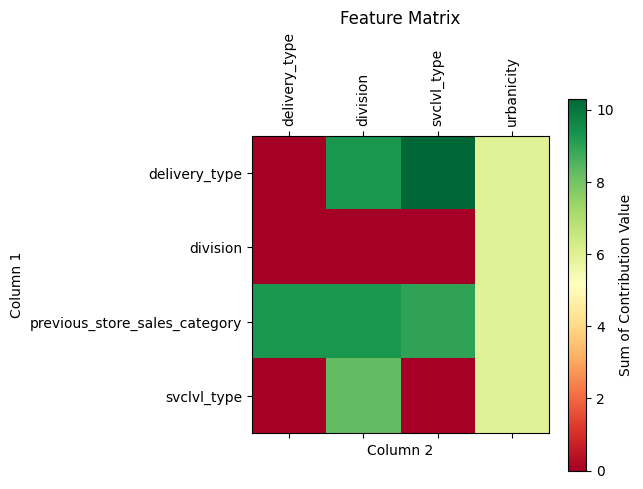

In [102]:
#Future section to build charts and tables
#
#///////////////////////////////////////////////////////////////////////
# CHARTS and TABLES
#///////////////////////////////////////////////////////////////////////
#
dfGraphs = pd.DataFrame()
dfGraphs = dfFINALOUTPUT.groupby(['COLUMN_1', 'COLUMN_2'])['TOTAL_CONTRIBUTION_60_DAYS'].sum().unstack(fill_value=0)

# plt.imshow(dfFINALOUTPUT.groupby(['COLUMN_1', 'COLUMN_2'])['TOTAL_CONTRIBUTION_60_DAYS'].sum(), cmap ="RdYlBu") 
  
plt.figure(figsize=(8, 6))
plt.matshow(dfGraphs, cmap='RdYlGn')  # You can choose a different colormap if desired
plt.xticks(range(len(dfGraphs.columns)), dfGraphs.columns, rotation=90)
plt.yticks(range(len(dfGraphs.index)), dfGraphs.index)
plt.xlabel('Column 2')
plt.ylabel('Column 1')
plt.title('Feature Matrix')
plt.colorbar(label='Sum of Contribution Value')
plt.show()



In [110]:
dfTesting = dfFINALOUTPUT

,TOTAL_CONTRIBUTION_30_DAYS,TOTAL_CONTRIBUTION_60_DAYS,FEATURES,NUM_FEATURES,NUM_HH_FIRST_TIMEPERIOD,NUM_HH_LAST_TIMEPERIOD,VARIANCE,RPT_RATE_60_BPS_DIFF,60_DAY_RATE_CONTRIBUTION,60_DAY_MIX_CONTRIBUTION,INDEX,COLUMN_1,COLUMN_2
0,45.268306,44.350385,previous_store_sales_category::delivery_type,2,210617.0,188728,-0.017126,380.430143,51.744834,-7.394449,"(A - NO_STORE_TXNS, DELIVERY)",previous_store_sales_category,delivery_type
189,36.967921,39.104106,delivery_type::urbanicity,2,143721.0,133582,-0.008229,442.288852,42.580394,-3.476288,"(DELIVERY, Urban)",delivery_type,urbanicity
158,36.503949,35.204107,delivery_type::svclvl_type,2,139067.0,145082,0.003443,318.179326,33.269114,1.934994,"(DELIVERY, EXPRESS)",delivery_type,svclvl_type
160,11.447495,16.036730,delivery_type::svclvl_type,2,232770.0,169896,-0.046806,284.303698,34.811393,-18.774663,"(DELIVERY, STANDARD)",delivery_type,svclvl_type
231,15.864553,15.647960,svclvl_type::urbanicity,2,162364.0,183073,0.013884,128.591983,16.966565,-1.318605,"(EXPRESS, Urban)",svclvl_type,urbanicity
...,...,...,...,...,...,...,...,...,...,...,...,...,...
191,-34.285376,-36.701126,delivery_type::urbanicity,2,484295.0,512719,0.017380,-91.249320,-33.718232,-2.982894,"(DUG, Suburban)",delivery_type,urbanicity
1,-48.286290,-62.956005,previous_store_sales_category::delivery_type,2,431372.0,466492,0.022545,-154.034831,-51.786776,-11.169229,"(A - NO_STORE_TXNS, DUG)",previous_store_sales_category,delivery_type
162,NaN,NaN,delivery_type::svclvl_type,2,NaN,49182,NaN,NaN,NaN,NaN,"(DUG, FLASH)",delivery_type,svclvl_type
206,NaN,NaN,svclvl_type::division,2,NaN,134,NaN,NaN,NaN,NaN,"(FLASH, HAGGEN)",svclvl_type,division


In [105]:
dfTesting['INDEX'] = dfTesting['INDEX'].str.join(' ').str.strip()

AttributeError: Can only use .str accessor with string values!